In [101]:

import os
from dotenv import load_dotenv

load_dotenv()
OPENAI_APIKEY = os.getenv("OPENAI_APIKEY")
APIKEY_ANTHROPIC = os.getenv("APIKEY_ANTHROPIC")
APIKEY_VOYAGER = os.getenv("APIKEY_VOYAGER")

In [2]:
import openai

# Replace 'your-api-key' with your actual OpenAI API key
openai.api_key = APIKEY

# openai.api_key = api_key

# Define the prompt
prompt = "If you had to choose, on a scale from 1 to 10, how cute are cats? Output a single integer."

# Request with logprobs
response = openai.Completion.create(
    model="text-davinci-003",  # Use a completion model
    prompt=prompt,
    max_tokens=1,              # Expecting a single integer
    temperature=0,             # Deterministic response
    logprobs=10                # Get log probabilities of top tokens
)

# Extract logprobs
logprobs = response.choices[0].logprobs.top_logprobs[0]

# Convert logprobs to probabilities
probabilities = {token: math.exp(logprob) for token, logprob in logprobs.items()}

# Filter and normalize probabilities for numbers 1-10
number_probabilities = {int(token.strip()): prob for token, prob in probabilities.items() if token.strip().isdigit() and 1 <= int(token.strip()) <= 10}
total_prob = sum(number_probabilities.values())
normalized_probabilities = {num: prob / total_prob for num, prob in number_probabilities.items()}

# Print normalized probabilities
print("Normalized Probabilities for Numbers 1-10:")
for number, probability in sorted(normalized_probabilities.items()):
    print(f"Number: {number}, Probability: {probability:.4f}")



APIRemovedInV1: 

You tried to access openai.Completion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742


In [25]:
from openai import AsyncOpenAI


aclient = AsyncOpenAI(
    api_key = APIKEY
)
async def get_log_probs(contents: str):
    response = await aclient.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": contents}],
        stream=True,
        logprobs=True,
    )
    token_log_probs = {}
    async for chunk in response:
        choice = chunk.choices[0]
        content = choice.delta.content
        log_probs = choice.logprobs
        print(log_probs)
        if content and log_probs:
            log_prob = log_probs.content[0].logprob
            token_log_probs[content] = log_prob
    return token_log_probs
log_probs = await get_log_probs("If you had to choose, on a scale from 1 to 10, how cute are cats? Output a single integer.")
log_probs

ChoiceLogprobs(content=[], refusal=None)
ChoiceLogprobs(content=[ChatCompletionTokenLogprob(token='9', bytes=[57], logprob=-0.25786915, top_logprobs=[])], refusal=None)
None


{'9': -0.25786915}

In [2]:
from openai import OpenAI
from math import exp
import numpy as np
from IPython.display import display, HTML
import os

client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY", APIKEY))

In [3]:
def get_completion(
    messages: list[dict[str, str]],
    model: str = "gpt-4",
    max_tokens=500,
    temperature=0,
    stop=None,
    seed=123,
    tools=None,
    logprobs=None,  # whether to return log probabilities of the output tokens or not. If true, returns the log probabilities of each output token returned in the content of message..
    top_logprobs=None,
) -> str:
    params = {
        "model": model,
        "messages": messages,
        "max_tokens": max_tokens,
        "temperature": temperature,
        "stop": stop,
        "seed": seed,
        "logprobs": logprobs,
        "top_logprobs": top_logprobs,
    }
    if tools:
        params["tools"] = tools

    completion = client.chat.completions.create(**params)
    return completion

In [4]:
CLASSIFICATION_PROMPT = """You will be given a headline of a news article.
Classify the article into one of the following categories: Technology, Politics, Sports, and Art.
Return only the name of the category, and nothing else.
MAKE SURE your output is one of the four categories stated.
Article headline: {headline}"""
headlines = [
    "Tech Giant Unveils Latest Smartphone Model with Advanced Photo-Editing Features.",
    "Local Mayor Launches Initiative to Enhance Urban Public Transport.",
    "Tennis Champion Showcases Hidden Talents in Symphony Orchestra Debut",
]

In [8]:
for headline in headlines:
    print(f"\nHeadline: {headline}")
    API_RESPONSE = get_completion(
        [{"role": "user", "content": CLASSIFICATION_PROMPT.format(headline=headline)}],
        model="gpt-4",
    )
    print(f"Category: {API_RESPONSE.choices[0].message.content}\n")


Headline: Tech Giant Unveils Latest Smartphone Model with Advanced Photo-Editing Features.
Category: Technology


Headline: Local Mayor Launches Initiative to Enhance Urban Public Transport.
Category: Politics


Headline: Tennis Champion Showcases Hidden Talents in Symphony Orchestra Debut
Category: Art



In [10]:
CLASSIFICATION_PROMPT.format(headline=headline)

'You will be given a headline of a news article.\nClassify the article into one of the following categories: Technology, Politics, Sports, and Art.\nReturn only the name of the category, and nothing else.\nMAKE SURE your output is one of the four categories stated.\nArticle headline: Tennis Champion Showcases Hidden Talents in Symphony Orchestra Debut'

# Classification of headlines

In [9]:


for headline in headlines:
    print(f"\nHeadline: {headline}")
    API_RESPONSE = get_completion(
        [{"role": "user", "content": CLASSIFICATION_PROMPT.format(headline=headline)}],
        model="gpt-4o",
        logprobs=True,
        top_logprobs=2,
    )
    top_two_logprobs = API_RESPONSE.choices[0].logprobs.content[0].top_logprobs
    html_content = ""
    for i, logprob in enumerate(top_two_logprobs, start=1):
        html_content += (
            f"<span style='color: cyan'>Output token {i}:</span> {logprob.token}, "
            f"<span style='color: darkorange'>logprobs:</span> {logprob.logprob}, "
            f"<span style='color: magenta'>linear probability:</span> {np.round(np.exp(logprob.logprob)*100,2)}%<br>"
        )
    display(HTML(html_content))
    print("\n")


Headline: Tech Giant Unveils Latest Smartphone Model with Advanced Photo-Editing Features.





Headline: Local Mayor Launches Initiative to Enhance Urban Public Transport.





Headline: Tennis Champion Showcases Hidden Talents in Symphony Orchestra Debut


In [13]:
# Article retrieved
ada_lovelace_article = """Augusta Ada King, Countess of Lovelace (née Byron; 10 December 1815 – 27 November 1852) was an English mathematician and writer, chiefly known for her work on Charles Babbage's proposed mechanical general-purpose computer, the Analytical Engine. She was the first to recognise that the machine had applications beyond pure calculation.
Ada Byron was the only legitimate child of poet Lord Byron and reformer Lady Byron. All Lovelace's half-siblings, Lord Byron's other children, were born out of wedlock to other women. Byron separated from his wife a month after Ada was born and left England forever. He died in Greece when Ada was eight. Her mother was anxious about her upbringing and promoted Ada's interest in mathematics and logic in an effort to prevent her from developing her father's perceived insanity. Despite this, Ada remained interested in him, naming her two sons Byron and Gordon. Upon her death, she was buried next to him at her request. Although often ill in her childhood, Ada pursued her studies assiduously. She married William King in 1835. King was made Earl of Lovelace in 1838, Ada thereby becoming Countess of Lovelace.
Her educational and social exploits brought her into contact with scientists such as Andrew Crosse, Charles Babbage, Sir David Brewster, Charles Wheatstone, Michael Faraday, and the author Charles Dickens, contacts which she used to further her education. Ada described her approach as "poetical science" and herself as an "Analyst (& Metaphysician)".
When she was eighteen, her mathematical talents led her to a long working relationship and friendship with fellow British mathematician Charles Babbage, who is known as "the father of computers". She was in particular interested in Babbage's work on the Analytical Engine. Lovelace first met him in June 1833, through their mutual friend, and her private tutor, Mary Somerville.
Between 1842 and 1843, Ada translated an article by the military engineer Luigi Menabrea (later Prime Minister of Italy) about the Analytical Engine, supplementing it with an elaborate set of seven notes, simply called "Notes".
Lovelace's notes are important in the early history of computers, especially since the seventh one contained what many consider to be the first computer program—that is, an algorithm designed to be carried out by a machine. Other historians reject this perspective and point out that Babbage's personal notes from the years 1836/1837 contain the first programs for the engine. She also developed a vision of the capability of computers to go beyond mere calculating or number-crunching, while many others, including Babbage himself, focused only on those capabilities. Her mindset of "poetical science" led her to ask questions about the Analytical Engine (as shown in her notes) examining how individuals and society relate to technology as a collaborative tool.
"""

# Questions that can be easily answered given the article
easy_questions = [
    "What nationality was Ada Lovelace?",
    "What was an important finding from Lovelace's seventh note?",
]

# Questions that are not fully covered in the article
medium_questions = [
    "Did Lovelace collaborate with Charles Dickens",
    "What concepts did Lovelace build with Charles Babbage",
]

In [14]:
PROMPT = """You retrieved this article: {article}. The question is: {question}.
Before even answering the question, consider whether you have sufficient information in the article to answer the question fully.
Your output should JUST be the boolean true or false, of if you have sufficient information in the article to answer the question.
Respond with just one word, the boolean true or false. You must output the word 'True', or the word 'False', nothing else.
"""

In [15]:
PROMPT

"You retrieved this article: {article}. The question is: {question}.\nBefore even answering the question, consider whether you have sufficient information in the article to answer the question fully.\nYour output should JUST be the boolean true or false, of if you have sufficient information in the article to answer the question.\nRespond with just one word, the boolean true or false. You must output the word 'True', or the word 'False', nothing else.\n"

In [17]:
html_output = ""
html_output += "Questions clearly answered in article"

for question in easy_questions:
    API_RESPONSE = get_completion(
        [
            {
                "role": "user",
                "content": PROMPT.format(
                    article=ada_lovelace_article, question=question
                ),
            }
        ],
        model="gpt-4",
        logprobs=True,
    )
    html_output += f'<p style="color:green">Question: {question}</p>'
    for logprob in API_RESPONSE.choices[0].logprobs.content:
        html_output += f'<p style="color:cyan">has_sufficient_context_for_answer: {logprob.token}, <span style="color:darkorange">logprobs: {logprob.logprob}, <span style="color:magenta">linear probability: {np.round(np.exp(logprob.logprob)*100,2)}%</span></p>'

html_output += "Questions only partially covered in the article"

for question in medium_questions:
    API_RESPONSE = get_completion(
        [
            {
                "role": "user",
                "content": PROMPT.format(
                    article=ada_lovelace_article, question=question
                ),
            }
        ],
        model="gpt-4",
        logprobs=True,
        top_logprobs=2,
    )
    html_output += f'<p style="color:green">Question: {question}</p>'
    for logprob in API_RESPONSE.choices[0].logprobs.content:
        html_output += f'<p style="color:cyan">has_sufficient_context_for_answer: {logprob.token}, <span style="color:darkorange">logprobs: {logprob.logprob}, <span style="color:magenta">linear probability: {np.round(np.exp(logprob.logprob)*100,2)}%</span></p>'

display(HTML(html_output))

# LOG PROB CODE

In [179]:
import pandas as pd
from typing import List, Optional
import math

def process_top_logprobs(
    top_logprobs: List,
    convert_type: Optional[str] = None
) -> pd.DataFrame:
    """
    Processes a list of TopLogprob objects into a pandas DataFrame with additional metrics.
    
    Parameters
    ----------
    top_logprobs : List
        A list of TopLogprob objects, each containing 'token', 'bytes', and 'logprob' attributes.
    
    convert_type : Optional[str], default=None
        Specifies the desired data type for the 'token' column.
        - 'int' : Convert tokens to integers.
        - 'float' : Convert tokens to floats.
        - 'bool' : Convert tokens to booleans.
        - None : No conversion applied.
        
        Tokens that cannot be converted to the specified type will be excluded from the DataFrame.
    
    Returns
    -------
    pd.DataFrame
        A pandas DataFrame with columns:
        - 'token' : The token, optionally converted to the specified type.
        - 'bytes' : The byte representation of the token.
        - 'logprob' : The log probability of the token.
        - 'prob' : The probability of the token, calculated as exp(logprob).
        - 'perplexity' : The perplexity, calculated as exp(-logprob).
    
    Raises
    ------
    ValueError
        If `convert_type` is not one of 'int', 'float', 'bool', or None.
        If `top_logprobs` is not a list.
        If any TopLogprob object does not have the required attributes.
    """
    
    # Input validation
    if not isinstance(top_logprobs, list):
        raise ValueError("`top_logprobs` must be a list of TopLogprob objects.")
    
    valid_types = {'int', 'float', 'bool', None}
    if convert_type not in valid_types:
        raise ValueError("`convert_type` must be one of 'int', 'float', 'bool', or None.")
    
    # Extract data
    data = []
    for idx, item in enumerate(top_logprobs):
        try:
            token = item.token
            bytes_list = item.bytes
            logprob = item.logprob
            prob = math.exp(logprob)
            perplexity = math.exp(-logprob)
            data.append({
                'token': token,
                'bytes': bytes_list,
                'logprob': logprob,
                'prob': prob,
                'perplexity': perplexity
            })
        except AttributeError as e:
            raise ValueError(f"TopLogprob object at index {idx} is missing required attributes.") from e
        except (TypeError, ValueError) as e:
            raise ValueError(f"Invalid data in TopLogprob object at index {idx}: {e}") from e
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    # Optional type conversion
    if convert_type:
        type_mapping = {
            'int': 'Int64',   # Use pandas nullable integer dtype
            'float': 'float64',
            'bool': 'bool'
        }
        dtype = type_mapping.get(convert_type)
        
        if convert_type == 'bool':
            # Define truthy values
            truthy_values = {'true', '1', 't', 'yes'}
            df['token_converted'] = df['token'].astype(str).str.lower().isin(truthy_values)
        else:
            df['token_converted'] = pd.to_numeric(df['token'], errors='coerce')
        
        # Drop rows where conversion failed (NaN values or False for bool)
        if convert_type == 'bool':
            df = df[df['token_converted'] == True]
        else:
            df = df.dropna(subset=['token_converted'])
            df['token_converted'] = df['token_converted'].astype(dtype)
        
        # Assign the converted column back to 'token' and drop the helper column
        df['token'] = df['token_converted']
        df = df.drop(columns=['token_converted'])
    
    return df

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_logprob_dataframe(
    df: pd.DataFrame,
    y_column: str = 'perplexity',
    palette: Optional[str] = 'viridis',
    use_beta_model: bool =True,
    figsize: tuple = (12, 8)
) -> None:
    """
    Plots a bar chart of the specified metric for each token with a density curve overlay.
    
    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame containing at least 'token' and the specified y_column.
    
    y_column : str, default='perplexity'
        The column to plot on the y-axis. Must be one of 'perplexity', 'logprob', or 'prob'.
    
    palette : Optional[str], default='viridis'
        The seaborn color palette to use for the bars.
    
    figsize : tuple, default=(12, 8)
        The size of the plot in inches, as (width, height).
    
    Returns
    -------
    None
        Displays the plot.
    
    Raises
    ------
    ValueError
        If `y_column` is not one of 'perplexity', 'logprob', or 'prob'.
        If required columns are missing from the DataFrame.
    """
    
    # Validate y_column
    valid_columns = {'perplexity', 'logprob', 'prob'}
    if y_column not in valid_columns:
        raise ValueError(f"`y_column` must be one of {valid_columns}.")
    
    # Check required columns in DataFrame
    required_columns = {'token', y_column}
    missing_columns = required_columns - set(df.columns)
    if missing_columns:
        raise ValueError(f"The DataFrame is missing required columns: {missing_columns}")
    
    # Sort the DataFrame by token (assuming tokens are numeric and sortable)
    df_sorted = df.sort_values(by='token')
    
    # Initialize the matplotlib figure
    plt.figure(figsize=figsize)
    
    # Set seaborn context for blog-friendly aesthetics
    sns.set_context("talk")
    sns.set_style("whitegrid")
    
    # Create the barplot using token as numeric x-axis
    plt.bar(
        x=df_sorted['token'],
        height=df_sorted[y_column],
        color=sns.color_palette(palette, len(df_sorted)),
        alpha=0.8,
        label="Bar Plot"
    )
    
    
    # Overlay density curve
    if use_beta_model:
        from scipy.stats import beta
        
        # Normalize the token values to (0, 1) for beta fitting
        epsilon = 1e-6  # A small value to shift the boundaries
        normalized_tokens = (df_sorted['token'] - 1) / (10 - 1)
        normalized_tokens = np.clip(normalized_tokens, epsilon, 1 - epsilon)
        
        # Fit a beta distribution to the normalized data
        a, b, loc, scale = beta.fit(normalized_tokens, floc=0, fscale=1)
        
        # Generate a smooth curve based on the beta distribution
        x = np.linspace(1, 10, 20)
        normalized_x = (x - 1) / (10 - 1)
        density = beta.pdf(normalized_x, a, b, loc=loc, scale=scale)

        # Ensure no infinite values in density
        density = np.where(np.isfinite(density), density, 0)
        
        # Scale density to align with weights (df_sorted[y_column])
        density *= np.sum(df_sorted[y_column]) / np.sum(density)

        
        # Plot the beta-modeled density
        plt.plot(x, density, color='blue', linewidth=2, label='Beta Model')
    else:
        pass
        # Default KDE plot with actual values
        # sns.kdeplot(
        #     x=df_sorted['token'],
        #     weights=df_sorted[y_column],
        #     color='red',
        #     linewidth=2,
        #     fill=False,
        #     label='Density'
        # )

    
    # Customize the plot
    plt.title(f'Bar Plot of {y_column.capitalize()} by Token', fontsize=16)
    plt.xlabel('Token', fontsize=14)
    plt.ylabel(y_column.capitalize(), fontsize=14)
    
    # Set x-axis range and ticks
    plt.xlim(0, 11)  # Ensure the x-axis always covers the range 0-11
    plt.xticks(ticks=range(1, 11), labels=range(1, 11))  # Set ticks at integers 1 through 10
    
    # Rotate x-axis labels if tokens are numerous or overlapping
    if len(df_sorted) > 10:
        plt.xticks(rotation=45, ha='right')
    # Hide the top and right spines
    sns.despine(top=True, right=True)
    
    # Add legend for density curve
    plt.legend()
    
    # Adjust layout for better fit
    plt.tight_layout()
    
    # Show the plot
    plt.show()



In [190]:
PROMPT = "Weather in London is predicted to be horribly hot this summer, even worse than last year, in 2023. Based on the information given, what is a likely temperature in celcius that is projected in the text? respond with a number as a rough guess"
PROMPT = "On a scale from 1 to 10 where 10 is the highest score. How much do you like lions?? Return a single number"

API_RESPONSE = get_completion(
    [
        {
            "role": "user",
            "content": PROMPT,
        }
    ],
    model="gpt-4o",
    logprobs=True,
    top_logprobs=15,
)


# Assuming you have the API_RESPONSE object as described
top_logprobs_list = API_RESPONSE.choices[0].logprobs.content[0].top_logprobs

# Process without type conversion
df_int = process_top_logprobs(top_logprobs_list) #, convert_type='int')
print(df_int)

     token                        bytes    logprob      prob     perplexity
0       As                    [65, 115]  -0.241009  0.785834       1.272533
1        8                         [56]  -1.991009  0.136558       7.322922
2        7                         [55]  -2.741009  0.064505      15.502622
3      I'm                [73, 39, 109]  -5.241009  0.005295     188.860567
4        I                         [73]  -5.366009  0.004673     214.007059
5        9                         [57]  -6.616009  0.001339     746.958031
6       10                     [49, 48]  -6.741009  0.001181     846.414337
7        6                         [54]  -7.991009  0.000338    2954.276321
8      I'd                [73, 39, 100]  -8.616010  0.000181    5519.320313
9     I'll           [73, 39, 108, 108] -10.991010  0.000017   59338.285464
10      My                    [77, 121] -11.116010  0.000015   67239.086381
11    It's           [73, 116, 39, 115] -11.116010  0.000015   67239.086381
12  That's  

    token bytes    logprob          prob    perplexity
0       3  [51]  -0.271906  7.619258e-01  1.312464e+00
1       2  [50]  -2.021906  1.324029e-01  7.552707e+00
2       4  [52]  -2.271906  1.031154e-01  9.697868e+00
3       5  [53]  -6.271906  1.888625e-03  5.294856e+02
4       1  [49]  -7.521906  5.411002e-04  1.848086e+03
6       6  [54] -10.271906  3.459138e-05  2.890894e+04
13      7  [55] -14.896906  3.391220e-07  2.948792e+06


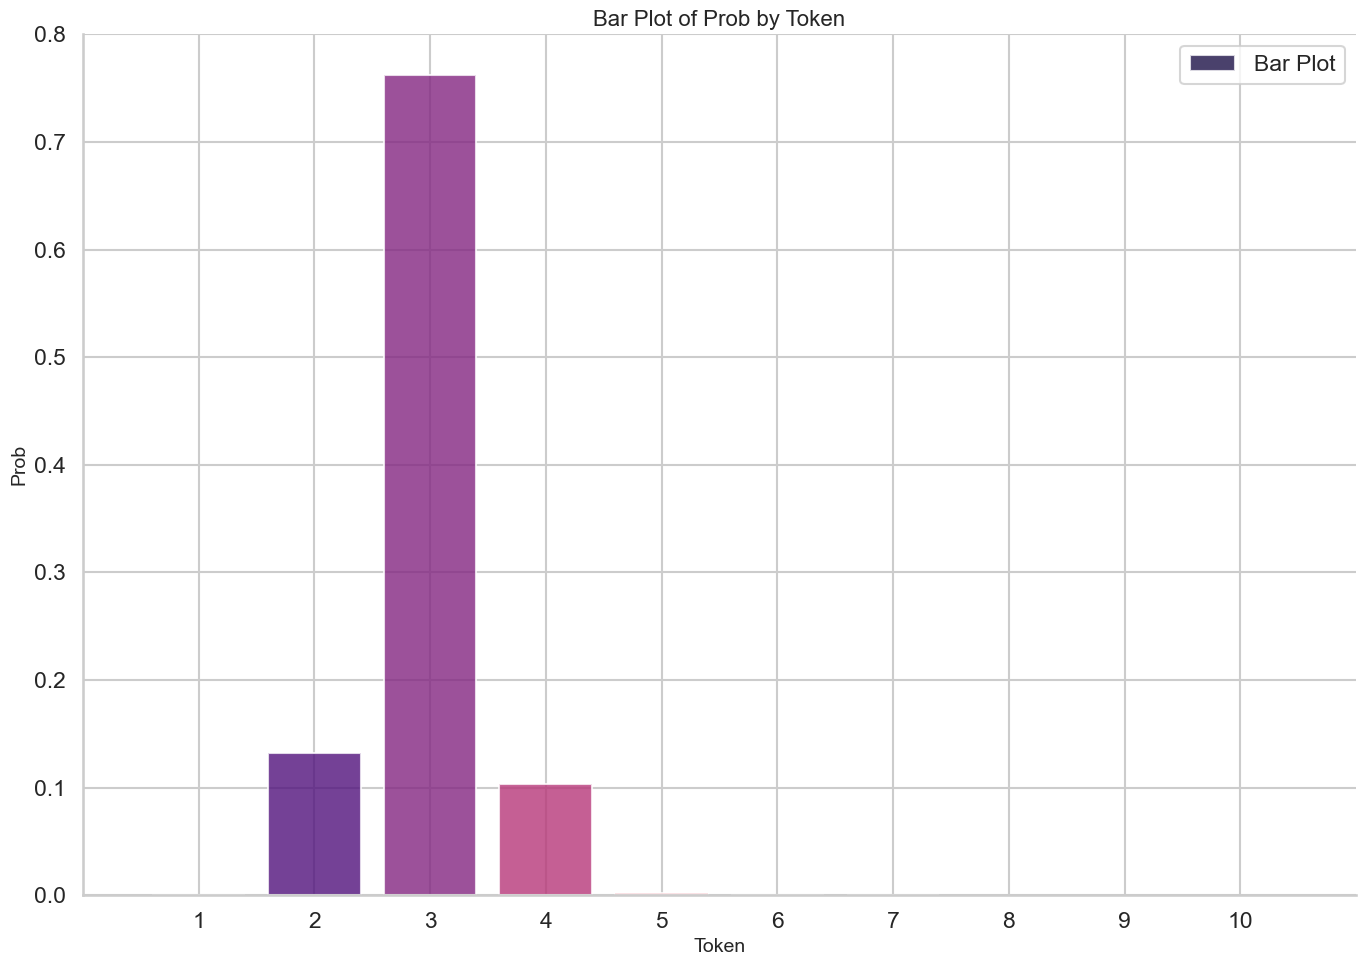

In [274]:
PROMPT= "If you had to pick your favourite number between 1 and 10 what would it be? Output a single integer"
PROMPT="On a scale from 1 to 10 where 10 is most likely. how likely is it that the humans destroy the earth by the year 2050. Just output a single integer"
# PROMPT="On a scale from 1 to 10 where 10 is most likely. how likely is it that ukraine join the EU soon. Just output a single integer"
# PROMPT="On a scale from 1 to 10 where 10 is most impactful. What is the negative biodiversity impact of Spotify. Just output a single integer"
# PROMPT = "Weather in London is predicted to be horribly cold this winter, even worse than last year, in 2023. On a scale of 1 (not) to 10 (very much), how much is this person looking forward to winter? Reply with a sinlge integer"
# PROMPT = "On a scale from 1 to 10 where 10 is the highest score. How much do you fear spiders? Think very carefully and Return a single number"

API_RESPONSE = get_completion(
    [
        {
            "role": "user",
            "content": PROMPT,
        }
    ],
    model="gpt-4o",
    logprobs=True,
    top_logprobs=15,
)


# Assuming you have the API_RESPONSE object as described
top_logprobs_list = API_RESPONSE.choices[0].logprobs.content[0].top_logprobs

# Process without type conversion
df_int = process_top_logprobs(top_logprobs_list, convert_type='int')
print(df_int)

plot_logprob_dataframe(df_int, y_column='prob', palette='magma', figsize=(14, 10), use_beta_model=False)


## embeddings

# test different types of embeddings:

# FULL CODE

# fullly worked out function:

## new code

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
File ratings_new/text-embedding-3-large_continuous_29topics_5phrasings.pkl not found; creating embeddings from scratch...


Fetching OpenAI (text-embedding-3-large) embeddings: 100%|██████████| 1450/1450 [11:08<00:00,  2.17it/s]


Saved new embeddings + config => ratings_new/text-embedding-3-large_continuous_29topics_5phrasings.pkl
Loaded embeddings shape: (1450, 3072)
Sample sentence: {'concept': 'evaluating the elegance of a fashion design', 'score': 1, 'text': 'We are evaluating the elegance of a fashion design on a scale of 1 to 10, my score is 1', 'phrasing': 1}


Computing MDS for each block: 100%|██████████| 145/145 [00:01<00:00, 76.37it/s]


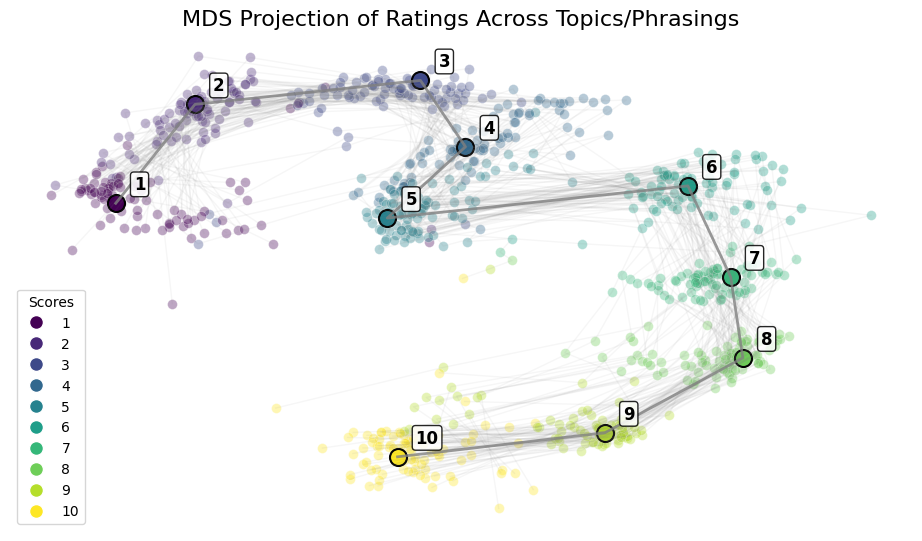

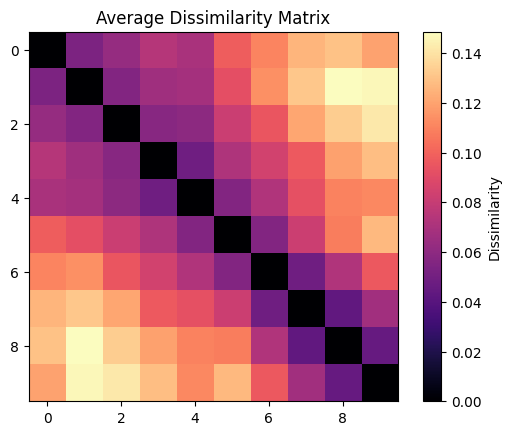

In [35]:
%load_ext autoreload
%autoreload 2

from LLM_representational_space import MDSProjector

# ========== 1) Create the projector instance ========== 
mds_proj = MDSProjector(api_key=OPENAI_APIKEY)

# ========== 2) Define your config ========== 
CONCEPTS = [
    # 🎨 Aesthetics & Creativity
    "evaluating the elegance of a fashion design",
    "judging the originality of a short story",
    "scoring the visual coherence of a photography portfolio",
    "rating the emotional resonance of a movie soundtrack",
    "assessing the depth of character development in a novel",
    "judging the poetic beauty of song lyrics",
    
    # 👅 Sensory & Physical Experience
    "judging the crunchiness of a fried snack",
    "rating the fragrance complexity of a perfume",
    "evaluating the spiciness of a dish",
    "scoring the richness of a chocolate dessert",
    "assessing the smoothness of a whiskey",
    "judging the balance of flavors in a gourmet meal",

    # ⚡ Performance & Usability
    "rating the clarity of a GPS navigation system",
    "evaluating the user-friendliness of an e-commerce website",
    "scoring the efficiency of a smartphone’s battery life",
    "judging the intuitiveness of a mobile game’s controls",
    "assessing the responsiveness of a touchscreen display",
    "rating the ease of learning a new software tool",

    # 🧠 Intellectual & Emotional Perception
    "judging the depth of a philosophical argument",
    "rating the persuasiveness of a political speech",
    "evaluating the accuracy of a history textbook",
    "scoring the thought-provoking nature of a documentary",
    "assessing the logical coherence of a scientific explanation",
    "judging the clarity of a professor’s lecture",

    # 🏗️ Practical & Functional Qualities
    "rating the durability of a hiking backpack",
    "evaluating the soundproofing effectiveness of an apartment",
    "scoring the fuel efficiency of a hybrid car",
    "judging the waterproof reliability of a raincoat",
    "assessing the sturdiness of a camping tent",
]

# rating_type: either "continuous" or "categorical"
config_rating_type = "continuous"  
num_phrasings = 5
model_name = "text-embedding-3-large"
# model_name = "sentence-transformers/all-MiniLM-L6-v2"
base_dir = "ratings_new"

# ========== 3) Load or generate embeddings ========== 
embedding_data = mds_proj.load_or_create_embeddings(
    concepts=CONCEPTS,
    model_name=model_name,
    rating_type=config_rating_type,
    num_phrasings=num_phrasings,
    base_dir=base_dir,     # e.g. "ratings" folder
    openai_api_key=OPENAI_APIKEY  # pass your key for embedding calls
)

# embedding_data now has:
# {
#   'config': { 'concepts': [...], 'model_name': ..., 'rating_type': ..., 'num_phrasings': ..., 'scores': [...] },
#   'sentences': [...],
#   'embeddings': np.ndarray
# }

embeddings = embedding_data["embeddings"]
config = embedding_data["config"]
all_sentences = embedding_data["sentences"]
the_scores = config["scores"]

print("Loaded embeddings shape:", embeddings.shape)
print("Sample sentence:", all_sentences[0])

# ========== 4) Compute MDS Projections ========== 
num_topics = len(CONCEPTS)
num_ratings = len(the_scores)           # MDSProjector automatically set self.scores
num_phrasings = config['num_phrasings'] # just to be sure

all_topics_points_2d, avg_points, all_dissimilarity_matrix = mds_proj.compute_mds_projections(
    embeddings=embeddings,
    num_topics=num_topics,
    num_ratings=num_ratings,
    num_phrasings=num_phrasings
)

# ========== 5) Plot the results ========== 
mds_proj.plot_results(
    all_topics_points_2d,
    avg_points,
    num_ratings=num_ratings,
    num_phrasings=num_phrasings,  # <-- pass it here
    selected_phrasings=[0,1,2],
    categorical=(config_rating_type == "categorical")
)

# You can also visualize the average dissimilarity matrix if you like:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
plt.title("Average Dissimilarity Matrix")
plt.imshow(np.mean(all_dissimilarity_matrix, axis=0), cmap='magma')
plt.colorbar(label="Dissimilarity")
plt.show()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
File ratings_new/sentence-transformers-all-mpnet-base-v2_continuous_29topics_2phrasings.pkl not found; creating embeddings from scratch...


Fetching HF (sentence-transformers/all-mpnet-base-v2) embeddings: 100%|██████████| 580/580 [00:38<00:00, 15.07it/s]


Saved new embeddings + config => ratings_new/sentence-transformers-all-mpnet-base-v2_continuous_29topics_2phrasings.pkl
Loaded embeddings shape: (580, 768)
Sample sentence: {'concept': 'evaluating the elegance of a fashion design', 'score': 1, 'text': 'We are evaluating the elegance of a fashion design on a scale of 1 to 10, my score is 1', 'phrasing': 1}


Computing MDS for each block: 100%|██████████| 58/58 [00:00<00:00, 88.46it/s]


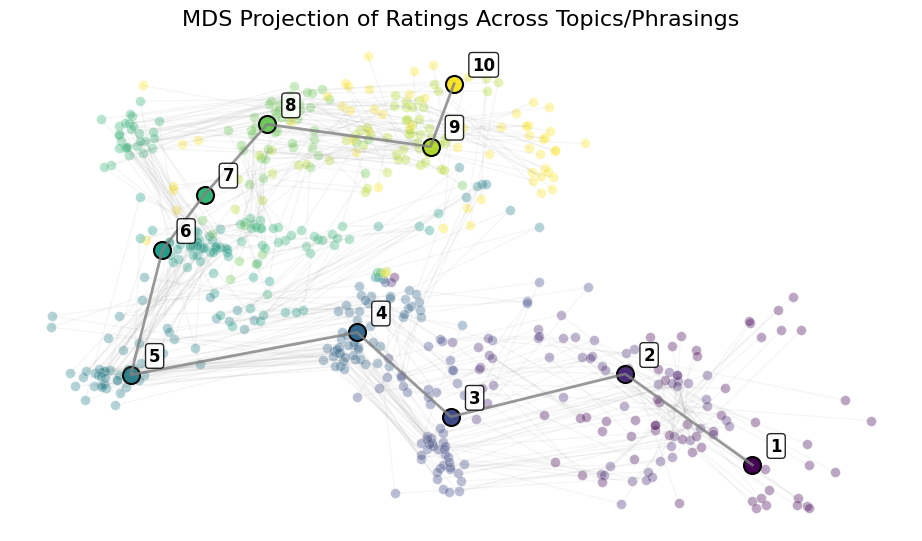

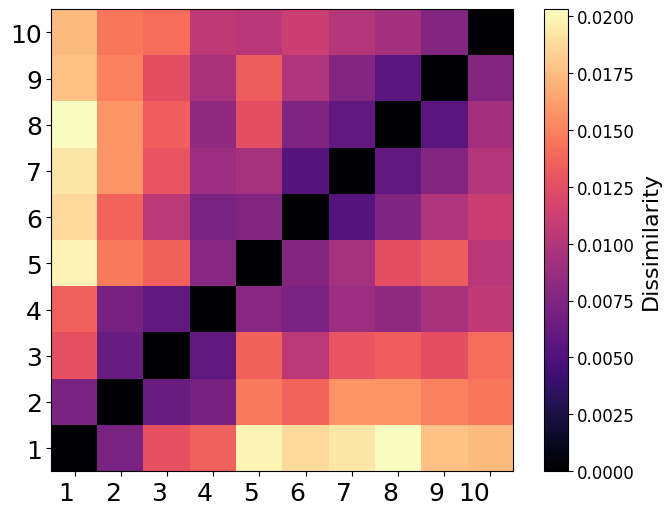

In [109]:
%load_ext autoreload
%autoreload 2

from LLM_representational_space import MDSProjector
%load_ext autoreload
%autoreload 2
# ========== 1) Create the projector instance ========== 
mds_proj = MDSProjector(api_key=OPENAI_APIKEY)

# ========== 2) Define your config ========== 
CONCEPTS = [
    # 🎨 Aesthetics & Creativity
    "evaluating the elegance of a fashion design",
    "judging the originality of a short story",
    "scoring the visual coherence of a photography portfolio",
    "rating the emotional resonance of a movie soundtrack",
    "assessing the depth of character development in a novel",
    "judging the poetic beauty of song lyrics",
    
    # 👅 Sensory & Physical Experience
    "judging the crunchiness of a fried snack",
    "rating the fragrance complexity of a perfume",
    "evaluating the spiciness of a dish",
    "scoring the richness of a chocolate dessert",
    "assessing the smoothness of a whiskey",
    "judging the balance of flavors in a gourmet meal",

    # ⚡ Performance & Usability
    "rating the clarity of a GPS navigation system",
    "evaluating the user-friendliness of an e-commerce website",
    "scoring the efficiency of a smartphone’s battery life",
    "judging the intuitiveness of a mobile game’s controls",
    "assessing the responsiveness of a touchscreen display",
    "rating the ease of learning a new software tool",

    # 🧠 Intellectual & Emotional Perception
    "judging the depth of a philosophical argument",
    "rating the persuasiveness of a political speech",
    "evaluating the accuracy of a history textbook",
    "scoring the thought-provoking nature of a documentary",
    "assessing the logical coherence of a scientific explanation",
    "judging the clarity of a professor’s lecture",

    # 🏗️ Practical & Functional Qualities
    "rating the durability of a hiking backpack",
    "evaluating the soundproofing effectiveness of an apartment",
    "scoring the fuel efficiency of a hybrid car",
    "judging the waterproof reliability of a raincoat",
    "assessing the sturdiness of a camping tent",
]

# rating_type: either "continuous" or "categorical"
config_rating_type = "continuous"  
num_phrasings = 2
model_name = "text-embedding-3-large" #3072
model_name = "sentence-transformers/all-MiniLM-L6-v2" #22.7M, 384 dim
model_name = "sentence-transformers/all-mpnet-base-v2" #109M, 768 dim
# model_name = "cohere/embed-english-v3.0" #1,024
# model_name = "text-embedding-3-small"  #1,536
# model_name = "gemini/models/text-embedding-004" # 768 dim

base_dir = "ratings_new"

# ========== 3) Load or generate embeddings ========== 
embedding_data = mds_proj.load_or_create_embeddings(
    concepts=CONCEPTS,
    model_name=model_name,
    rating_type=config_rating_type,
    num_phrasings=num_phrasings,
    base_dir=base_dir,     # e.g. "ratings" folder
    openai_api_key=OPENAI_APIKEY  # pass your key for embedding calls
)

# embedding_data now has:
# {
#   'config': { 'concepts': [...], 'model_name': ..., 'rating_type': ..., 'num_phrasings': ..., 'scores': [...] },
#   'sentences': [...],
#   'embeddings': np.ndarray
# }

embeddings = embedding_data["embeddings"]
config = embedding_data["config"]
all_sentences = embedding_data["sentences"]
the_scores = config["scores"]

print("Loaded embeddings shape:", embeddings.shape)
print("Sample sentence:", all_sentences[0])

# ========== 4) Compute MDS Projections ========== 
num_topics = len(CONCEPTS)
num_ratings = len(the_scores)           # MDSProjector automatically set self.scores
num_phrasings = config['num_phrasings'] # just to be sure

all_topics_points_2d, avg_points, all_dissimilarity_matrix = mds_proj.compute_mds_projections(
    embeddings=embeddings,
    num_topics=num_topics,
    num_ratings=num_ratings,
    num_phrasings=num_phrasings
)

# ========== 5) Plot the results ========== 
mds_proj.plot_results(
    all_topics_points_2d,
    avg_points,
    num_ratings=num_ratings,
    num_phrasings=num_phrasings,  # <-- pass it here
    selected_phrasings=[0,1,2],
    categorical=(config_rating_type == "categorical")
)

# You can also visualize the average dissimilarity matrix if you like:
import matplotlib.pyplot as plt
import numpy as np


# Define labels
if config_rating_type == 'categorical':
    labels = ["dreadful", "terrible", "inadequate", "mediocre", "acceptable", 
            "decent", "good", "great", "excellent", "superb", "magnificent", "perfect"]
else:
    labels = [str(i) for i in range(1,11)]
# Compute the average dissimilarity matrix
avg_dissimilarity = np.mean(all_dissimilarity_matrix, axis=0)


# Create figure
plt.figure(figsize=(8, 6))
# plt.title(" ", fontsize=14)
# Plot the heatmap
plt.imshow(avg_dissimilarity, cmap='magma')
# Add colorbar
# plt.colorbar(label="Dissimilarity")
# Set the x and y labels
labels = [label.capitalize() for label in labels]
plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=0, ha='right', fontsize=18)
plt.yticks(ticks=np.arange(len(labels)), labels=labels, fontsize=18)
# Flip the y-axis
plt.gca().invert_yaxis()
cbar = plt.colorbar()  
cbar.set_label("Dissimilarity", fontsize=16)  # Set larger font size for the title
cbar.ax.tick_params(labelsize=12)  # Increase tick font size

# Save the plot
plt.savefig("outputs/dissimilarity_projection_categorical_v1.svg", bbox_inches='tight', format='svg')
# Show the plot
plt.show()



# EVALUATE MATRICES

In [110]:
# Example model configurations
MODELS_CONFIG = [
    {
        "name": "text-embedding-3-large", 
        "dim": 3072,         # Embedding dimension for reference
        "num_phrasings": 5
    },
    {
        "name": "sentence-transformers/all-MiniLM-L6-v2", 
        "dim": 384, 
        "num_phrasings": 5
    },
    {
        "name": "sentence-transformers/all-mpnet-base-v2", 
        "dim": 768, 
        "num_phrasings": 2
    },
    {
        "name": "cohere/embed-english-v3.0", 
        "dim": 1024, 
        "num_phrasings": 2
    },
    {
        "name": "text-embedding-3-small", 
        "dim": 1536, 
        "num_phrasings": 2
    },
    {
        "name": "gemini/models/text-embedding-004", 
        "dim": 768, 
        "num_phrasings": 2
    }
]


## 2) Function to Compute Dissimilarity Matrices for Each Model

In [111]:
import numpy as np

def compute_dissimilarity_for_models(
    mds_proj, 
    models_config, 
    concepts, 
    rating_type, 
    base_dir, 
    openai_api_key
):
    """
    For each model in models_config:
      1) Load or create embeddings
      2) Compute average dissimilarity
      3) Return list of dictionaries with model info & the average dissimilarity matrix
    """
    results = []

    for model_info in models_config:
        model_name = model_info["name"]
        num_phrasings = model_info["num_phrasings"]
        embed_dim_ref = model_info["dim"]  # For reference/labeling

        # === LOAD OR CREATE EMBEDDINGS ===
        embedding_data = mds_proj.load_or_create_embeddings(
            concepts=concepts,
            model_name=model_name,
            rating_type=rating_type,
            num_phrasings=num_phrasings,
            base_dir=base_dir,
            openai_api_key=openai_api_key
        )

        embeddings = embedding_data["embeddings"]
        config = embedding_data["config"]
        all_scores = config["scores"]
        num_topics = len(concepts)
        num_ratings = len(all_scores)

        # Just in case, override num_phrasings from config
        num_phrasings = config["num_phrasings"]

        # === COMPUTE MDS PROJECTIONS & DISSIMILARITIES ===
        # The function returns (list of 2D points, avg_points, list of dissimilarities)
        _, _, all_dissimilarity_matrix = mds_proj.compute_mds_projections(
            embeddings=embeddings,
            num_topics=num_topics,
            num_ratings=num_ratings,
            num_phrasings=num_phrasings
        )

        # Average the dissimilarities across all blocks
        avg_dissimilarity = np.mean(all_dissimilarity_matrix, axis=0)

        results.append({
            "model_name": model_name,
            "dim": embed_dim_ref,
            "avg_dissimilarity": avg_dissimilarity,
            "num_phrasings": num_phrasings
        })
    
    return results


## 3) Function to Compare Each Average Dissimilarity Matrix Against a Linear Proxy


In [112]:
import pandas as pd
from scipy.stats import pearsonr

def compare_dissimilarity_to_linear(results):
    """
    Given a list of result dicts (model_name, dim, avg_dissimilarity),
    compute the correlation with a linear scale from 1..10.
    Returns a DataFrame with columns: [model_name, dim, correlation].
    """

    # We'll assume there are always 10 rating levels (1..10).
    # If your number of ratings changes, adapt the code below.
    n_ratings = 10

    # Create a list to hold final metrics
    metrics_list = []

    # Precompute our "linear" reference dissimilarity
    # This is |i - j| for i,j in [1..10]
    rating_range = np.arange(1, n_ratings + 1)
    linear_dissimilarity = np.abs(np.subtract.outer(rating_range, rating_range))
    # Flatten the upper triangle (excluding diagonal)
    linear_flat = linear_dissimilarity[np.triu_indices(n_ratings, k=1)]

    for item in results:
        model_name = item["model_name"]
        embed_dim = item["dim"]
        avg_diss = item["avg_dissimilarity"]

        # Flatten the upper triangle
        actual_flat = avg_diss[np.triu_indices(n_ratings, k=1)]

        # Compute Pearson correlation
        overlap, _ = pearsonr(actual_flat, linear_flat)

        # Add to metrics list
        metrics_list.append({
            "model_name": model_name,
            "embedding_dim": embed_dim,
            "correlation": overlap
        })

    # Convert to DataFrame
    df_metrics = pd.DataFrame(metrics_list)
    return df_metrics


## 4) Plot Function: Bar Plot of Correlations

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_correlation_bar(df_metrics, output_path="model_correlations.png"):
    """
    Plots a horizontal bar chart of model correlation with linear dissimilarity.

    - The x-axis represents correlation.
    - The y-axis labels show:
        1. Company name on the first line (e.g., OpenAI, Cohere, Google, Open Source)
        2. Model dimensionality in brackets (e.g., "3072D")
        3. Model name on the second line (e.g., "text-embedding-3-large")
    - Bars are shaded in subtle grayscale (higher correlation = slightly darker grey).
    """

    # Sort models by correlation (Highest at the top)
    df_sorted = df_metrics.sort_values(by="correlation", ascending=False)

    # Function to extract company name
    def extract_company(model_name):
        if model_name.startswith("text-embedding"):
            return "OpenAI"
        elif model_name.startswith("cohere"):
            return "Cohere"
        elif model_name.startswith("gemini"):
            return "Google"
        elif "sentence-transformers" in model_name:
            return "Open Source"
        else:
            return "Other"

    # Generate labels: Company Name + Dimensionality on 1st line, Model on 2nd line
    df_sorted["company"] = df_sorted["model_name"].apply(extract_company)
    df_sorted["label"] = df_sorted.apply(
        lambda row: f"{row['company']} ({row['embedding_dim']}D)\n{row['model_name']}", axis=1
    )

    # Normalize correlation values for grayscale shading (restricted range to avoid extremes)
    min_corr, max_corr = df_sorted["correlation"].min(), df_sorted["correlation"].max()
    df_sorted["color_intensity"] = 0.8 - 0.4 * (df_sorted["correlation"] - min_corr) / (max_corr - min_corr)

    # Set Seaborn style
    sns.set(style="whitegrid")

    # Create figure
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        x="correlation",
        y="label",
        data=df_sorted,
        palette=[(c, c, c) for c in df_sorted["color_intensity"]],  # Subtle grayscale
        edgecolor="lightgrey"
    )

    # Title and labels
    plt.title("Correlation with Linear Dissimilarity", fontsize=16, weight="bold")
    plt.xlabel("Pearson Correlation", fontsize=14)
    plt.ylabel("")

    # Remove top and right borders for cleaner look
    sns.despine(top=True, right=True, left=False, bottom=False)

    # Add correlation values inside the bars
    for i, bar in enumerate(ax.patches):
        plt.text(
            bar.get_width() + 0.02,  # Position slightly right of the bar
            bar.get_y() + bar.get_height() / 2,
            f"{df_sorted.iloc[i]['correlation']:.2f}",
            va='center',
            fontsize=12
        )

    # Save & Show Plot
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight', format="png")
    plt.savefig(output_path, dpi=300, bbox_inches='tight', format="svg")

    plt.show()


/var/folders/2n/qlp29c0j3wl7sxxgspr63c7h0000gn/T/ipykernel_28616/1593443279.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


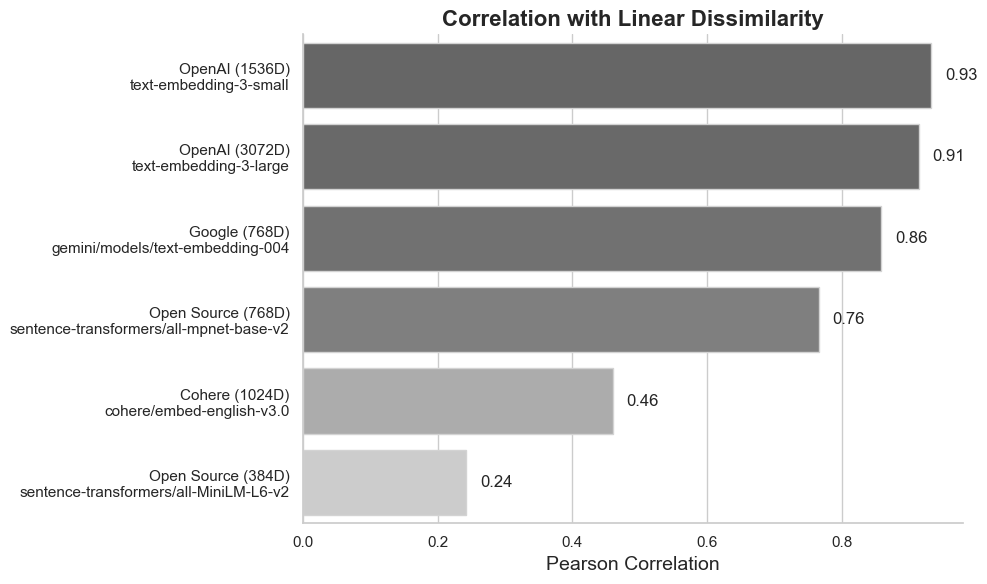

In [122]:
# Step 1: Compute dissimilarities
results = compute_dissimilarity_for_models(
    mds_proj=mds_proj,
    models_config=MODELS_CONFIG,
    concepts=CONCEPTS,
    rating_type="continuous",    # or "categorical"
    base_dir="ratings_new",
    openai_api_key=OPENAI_APIKEY
)

# Step 2: Compare to linear dissimilarity
df_metrics = compare_dissimilarity_to_linear(results)
print(df_metrics)
plot_correlation_bar(df_metrics, output_path="outputs/model_correlations.svg")
